<a href="https://colab.research.google.com/github/LeonardoLuca/IMDB_DataScience/blob/main/Classificadores_IMDB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas e carregando dataset

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [33]:
# Carregando o dataset. Note que a primeira coluna é o índice, então 'index_col=0'

df = pd.read_csv('Top_1000_IMDb_movies.csv', index_col=0)

print(df.head())

                 Movie Name Year of Release  Watch Time  Movie Rating  \
0  The Shawshank Redemption            1994         142           9.3   
1             The Godfather            1972         175           9.2   
2           The Dark Knight            2008         152           9.0   
3          Schindler's List            1993         195           9.0   
4              12 Angry Men            1957          96           9.0   

   Metascore of movie   Gross      Votes  \
0                82.0   28.34  27,77,378   
1               100.0  134.97  19,33,588   
2                84.0  534.86  27,54,087   
3                95.0    96.9  13,97,886   
4                97.0    4.36   8,24,211   

                                         Description  
0  Over the course of several years, two convicts...  
1  Don Vito Corleone, head of a mafia family, dec...  
2  When the menace known as the Joker wreaks havo...  
3  In German-occupied Poland during World War II,...  
4  The jury in a New 

# Tratamento e comparação

In [34]:
# 1.2. Tratamento de valores faltantes e inconsistentes
# As colunas 'Gross' e 'Votes' têm vírgulas e aspas. Precisamos limpá-las.
# A coluna 'Gross' tem 'M' no final para Milhões.
def clean_numeric_column(col):
    col = col.astype(str).str.replace(',', '').str.replace('"', '').str.strip()
    return pd.to_numeric(col, errors='coerce')

df['Votes'] = clean_numeric_column(df['Votes'])

# Para 'Gross', a lógica é um pouco diferente devido ao 'M'
df['Gross'] = df['Gross'].astype(str).str.replace(',', '').str.replace('M', '').str.replace('"', '').str.strip()
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce') * 1000000

# Verifique novamente as informações do dataset para confirmar a limpeza
print("\nInformações após a limpeza:")
df.info()


Informações após a limpeza:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie Name          1000 non-null   object 
 1   Year of Release     1000 non-null   object 
 2   Watch Time          1000 non-null   int64  
 3   Movie Rating        1000 non-null   float64
 4   Metascore of movie  845 non-null    float64
 5   Gross               837 non-null    float64
 6   Votes               1000 non-null   int64  
 7   Description         1000 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 70.3+ KB


In [35]:
# 1.3. Análise dos dados faltantes (valores nulos)
print("\nContagem de valores nulos por coluna:")
print(df.isnull().sum())



Contagem de valores nulos por coluna:
Movie Name              0
Year of Release         0
Watch Time              0
Movie Rating            0
Metascore of movie    155
Gross                 163
Votes                   0
Description             0
dtype: int64


In [36]:
# No seu caso, 'Gross' tem valores nulos. Vamos preencher com a mediana.
# A mediana é menos sensível a outliers do que a média.
df['Gross'].fillna(df['Gross'].median(), inplace=True)
df['Metascore of movie'].fillna(df['Metascore of movie'].median(), inplace=True)

# 1.4. Análise da distribuição das variáveis numéricas
# Vamos classificar filmes com 'Movie Rating' >= 8.8 como 'Excelente' (1) e abaixo como 'Bom' (0)
df['Target'] = df['Movie Rating'].apply(lambda x: 1 if x >= 8.8 else 0)

print("\nDistribuição da variável 'Target':")
print(df['Target'].value_counts(normalize=True))



Distribuição da variável 'Target':
Target
0    0.983
1    0.017
Name: proportion, dtype: float64


/tmp/ipython-input-3787797521.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gross'].fillna(df['Gross'].median(), inplace=True)
/tmp/ipython-input-3787797521.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

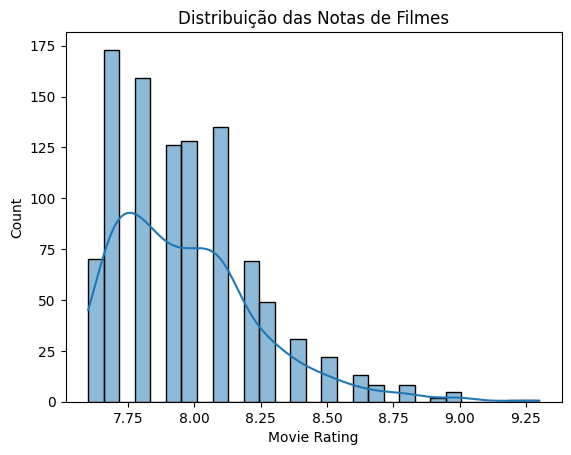

In [37]:
# 1.5. Visualização da distribuição
# Distribuição das notas de filmes
sns.histplot(df['Movie Rating'], kde=True)
plt.title('Distribuição das Notas de Filmes')
plt.show()


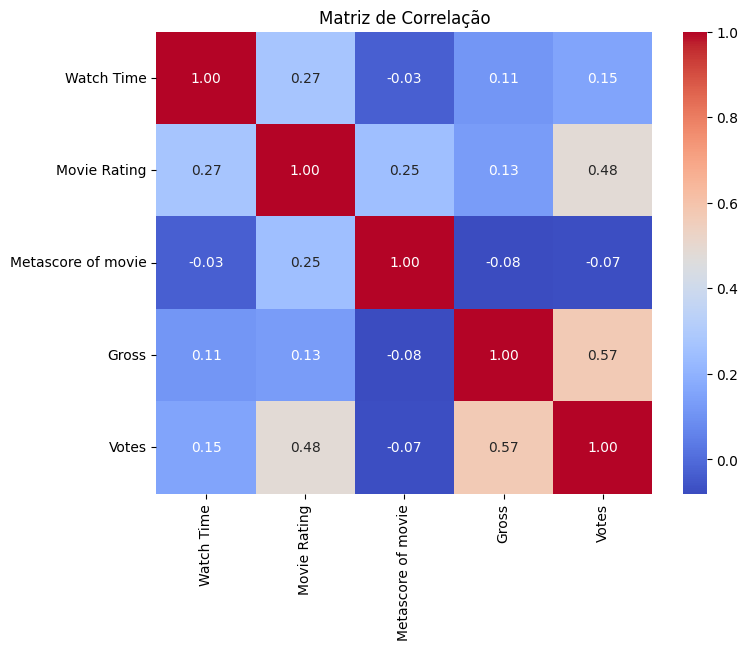

In [38]:
# Matriz de correlação entre as variáveis numéricas
numeric_cols = ['Watch Time', 'Movie Rating', 'Metascore of movie', 'Gross', 'Votes']
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

# Classificadores

In [39]:
# Selecionando as features (X) e o target (y)
features = ['Watch Time', 'Metascore of movie', 'Gross', 'Votes']
X = df[features]
y = df['Target']

# Por que usar 'stratify=y'?
# Isso garante que a proporção de filmes 'Excelente' (classe 1) e 'Bom' (classe 0)
# seja a mesma nos conjuntos de treino e teste. Isso é crucial para dados desbalanceados,
# pois evita que o conjunto de teste tenha pouquíssimos exemplos da classe minoritária.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Por que padronizar os dados?
# Modelos como Regressão Logística e SVM calculam distâncias e coeficientes.
# Se as features estiverem em escalas muito diferentes (ex: 'Gross' em milhões e 'Watch Time' em dezenas),
# a feature com a maior escala dominará o cálculo, e as outras perderão importância.
# A padronização (StandardScaler) ajusta todas as features para a mesma escala,
# com média 0 e desvio padrão 1, garantindo que todas tenham a mesma "voz" no modelo.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# Inicializando os classificadores
log_reg = LogisticRegression(random_state=42)
svm = SVC(kernel='rbf', random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Dicionário para armazenar os modelos treinados
models = {
    'Regressão Logística': log_reg,
    'SVM': svm,
    'Floresta Aleatória': random_forest
}

# Treinando cada modelo
for name, model in models.items():
    print(f"\nTreinando o modelo: {name}")
    # Usando dados escalados para LogReg e SVM, e dados originais para RF
    if name == 'Floresta Aleatória':
        model.fit(X_train, y_train)
    else:
        model.fit(X_train_scaled, y_train)
    print("Treinamento concluído.")


Treinando o modelo: Regressão Logística
Treinamento concluído.

Treinando o modelo: SVM
Treinamento concluído.

Treinando o modelo: Floresta Aleatória
Treinamento concluído.



--- Comparação de Resultados ---

Resultados para o modelo: Regressão Logística
Acurácia: 0.9933
F1-Score: 0.9933


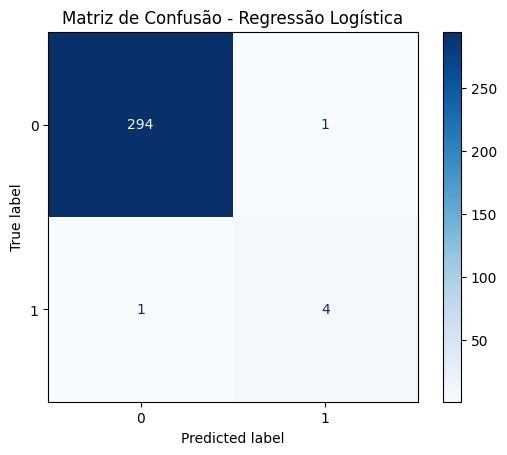


Resultados para o modelo: SVM
Acurácia: 0.9867
F1-Score: 0.9867


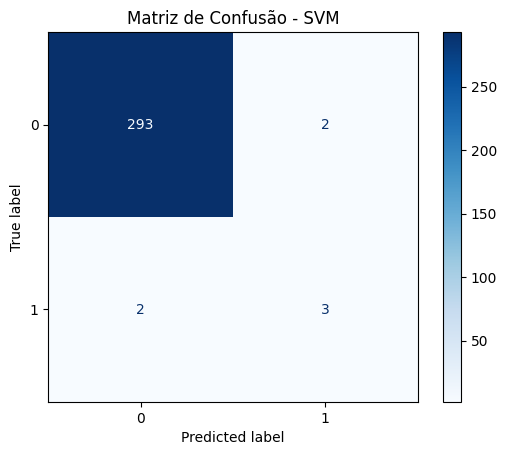


Resultados para o modelo: Floresta Aleatória
Acurácia: 0.9833
F1-Score: 0.9824


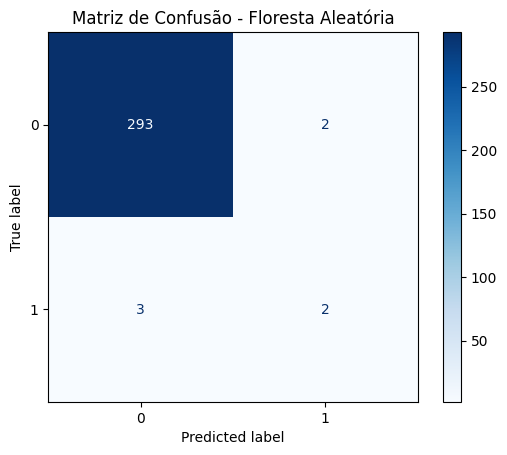


Tabela de Comparação de Métricas:
                     Acurácia  F1-Score
Regressão Logística  0.993333  0.993333
SVM                  0.986667  0.986667
Floresta Aleatória   0.983333  0.982422


In [42]:
print("\n--- Comparação de Resultados ---")
results = {}

for name, model in models.items():
    if name == 'Floresta Aleatória':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {'Acurácia': accuracy, 'F1-Score': f1}

    print(f"\nResultados para o modelo: {name}")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

# Tabela de resultados
results_df = pd.DataFrame(results).T
print("\nTabela de Comparação de Métricas:")
print(results_df)

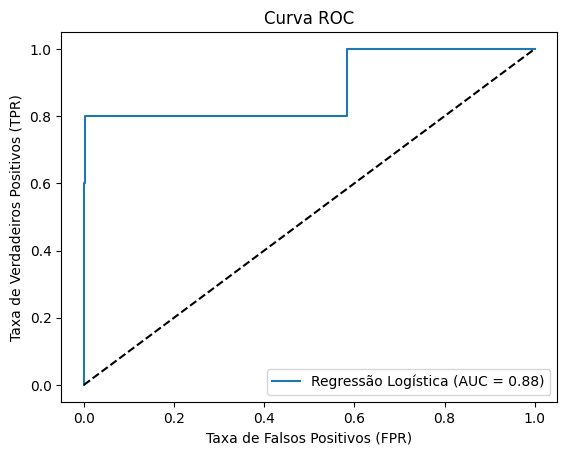

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score

# Para cada modelo, você precisará da probabilidade das previsões, não apenas da classe final.
y_scores = log_reg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f'Regressão Logística (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Linha de um classificador aleatório
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

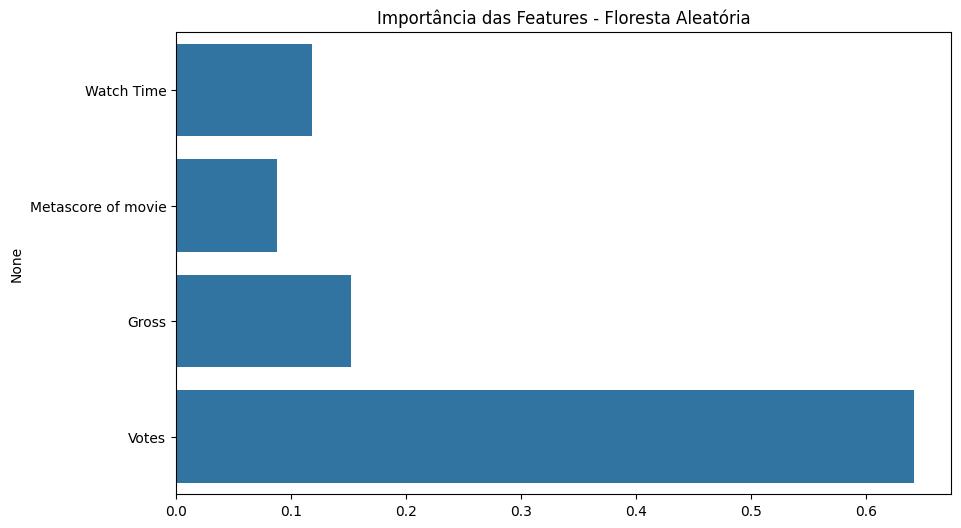

In [44]:
# Apenas para o modelo Random Forest
importances = random_forest.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Importância das Features - Floresta Aleatória')
plt.show()